# مدل آیزینگ

In [ ]:
import numpy as np
from scipy.ndimage import convolve
N = 10

class IsingModel(np.ndarray):
    def __new__(cls , N , *args , **kwargs ):
        obj = np.random.choice([1 , -1] , size=[N,N] ).view(cls)
        return obj

    def __array_finalize__(self , obj):
        if obj is None: return

    def __init__(self , N):
        self.N = N
        self._filter = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

    def magnetization(self):
        return float(np.sum(self))

    @property
    def filter(self):
        return self._filter

    def energy(self):
        n_sum = convolve(self , self.filter , mode='wrap')
        return float(-0.5*np.sum( self*n_sum ))

    def monte_carlo_step(self, temperature : float , steps : int = -1 ):
        """
            Perform a single Monte Carlo sweep with sequential spin updates.
            Returns the number of accepted spin flips.    
        """
        accepted = 0
        
        energies = 0
        magnetizations = 0

        n_sum = convolve(self , self.filter , mode='wrap') 
        steps = steps if steps > 0 else self.N ** 2
        for _ in range(steps):  # A full sweep over the lattice
            # Randomly choose a spin to update
            i = np.random.randint(0, self.N-1)
            j = np.random.randint(0, self.N-1)

            # Calculate the energy change if this spin is flipped
            delta_E = 2 * self[i, j] * n_sum[i, j]
            # Apply Metropolis criterion
            if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / temperature):
                self[i, j] *= -1  # Flip the spin
                accepted += 1

                # Update the n_sum matrix around the (i, j) element
                n_sum[ i+1 % self.N , j] += 2 * self[i, j]
                n_sum[ i-1 , j] += 2 * self[i, j]
                n_sum[ i , j+1 % self.N] += 2 * self[i, j]
                n_sum[ i , j-1] += 2 * self[i, j]
            energies += self.energy()
            magnetizations += self.magnetization()
        return accepted , energies/steps , magnetizations/steps


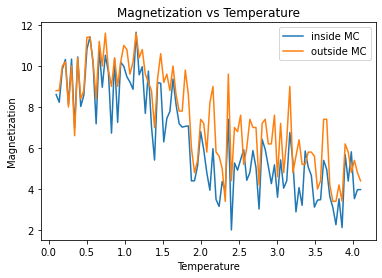

In [12]:
from matplotlib import pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor , as_completed 
#from tqdm import tqdm_notebook as tqdm

N = 4

def simulate_ising_model(T):
    E, M, A = [], [], []
    E_ , M_ = [] , []
    for _ in range(200):
        model = IsingModel(N)
        a , e , m = model.monte_carlo_step(T , 2000 )
        E.append(e)
        M.append(abs(m))
        A.append(a)

        E_.append(model.energy())
        M_.append(model.magnetization())
    return T, E, M, A , E_ , M_

temperatures = np.linspace(0.1, 4.1, 100)


# #with tqdm(total=len(temperatures), desc="Overall Progress") as pbar:
# with ThreadPoolExecutor() as executor:
#     futures = {executor.submit(simulate_ising_model, T): T for T in temperatures}
#     results = []
#     i = 0
#     for future in as_completed(futures):
#         T, E, M, A = future.result()
#         results.append((T, E, M, A))
#         i += 1
#         print(i)  # Update the overall progress bar

with ThreadPoolExecutor() as executor:
    results = list(executor.map(simulate_ising_model, temperatures ))

M_avg_in = []
M_avg_out = []
for T, E, M, A , E_ , M_ in results:
    # fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    # fig.suptitle(f"T={T:.2f}")
    # axs[0].plot(M, label="inside MC")
    # axs[0].plot(M_, label="outside MC")
    # axs[0].set_ylabel("Magnetization")
    # axs[0].legend()
    # axs[1].plot(E, label="inside MC")
    # axs[1].plot(E_, label="outside MC")
    # axs[1].set_ylabel("Energy")
    # axs[1].legend()
    # axs[2].plot(A, label=f"T={T:.2f}")
    # axs[2].set_ylabel("Acceptance rate")
    # axs[2].set_xlabel("Monte Carlo steps")
    # axs[2].legend()
    # plt.show()

    M_avg_out.append(np.mean(np.abs( np.array(M_) )[-10:]))
    M_avg_in.append(np.mean(np.abs( np.array(M) )[-10:]))

plt.plot(temperatures, M_avg_in , label="inside MC")
plt.plot(temperatures, M_avg_out , label="outside MC")
plt.legend()
plt.title("Magnetization vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.show()

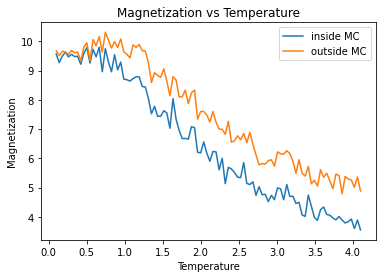

In [14]:
M_avg_in = []
M_avg_out = []
for T, E, M, A , E_ , M_ in results:
    # fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    # fig.suptitle(f"T={T:.2f}")
    # axs[0].plot(M, label="inside MC")
    # axs[0].plot(M_, label="outside MC")
    # axs[0].set_ylabel("Magnetization")
    # axs[0].legend()
    # axs[1].plot(E, label="inside MC")
    # axs[1].plot(E_, label="outside MC")
    # axs[1].set_ylabel("Energy")
    # axs[1].legend()
    # axs[2].plot(A, label=f"T={T:.2f}")
    # axs[2].set_ylabel("Acceptance rate")
    # axs[2].set_xlabel("Monte Carlo steps")
    # axs[2].legend()
    # plt.show()

    M_avg_out.append(np.mean(np.abs( np.array(M_) )))
    M_avg_in.append(np.mean(np.abs( np.array(M) )))

plt.plot(temperatures, M_avg_in , label="inside MC")
plt.plot(temperatures, M_avg_out , label="outside MC")
plt.legend()
plt.title("Magnetization vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.show()